In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio
import matplotlib.pyplot as plt
from tqdm import tqdm

from data import SyntheticNotesDataset
from model import WaveNetAutoencoder, DisentangledWaveNetAE
from train import train_model, train_disentangled
from eval import evaluate_with_pitch_control, evaluate_model

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Generated note with MIDI pitch: 29


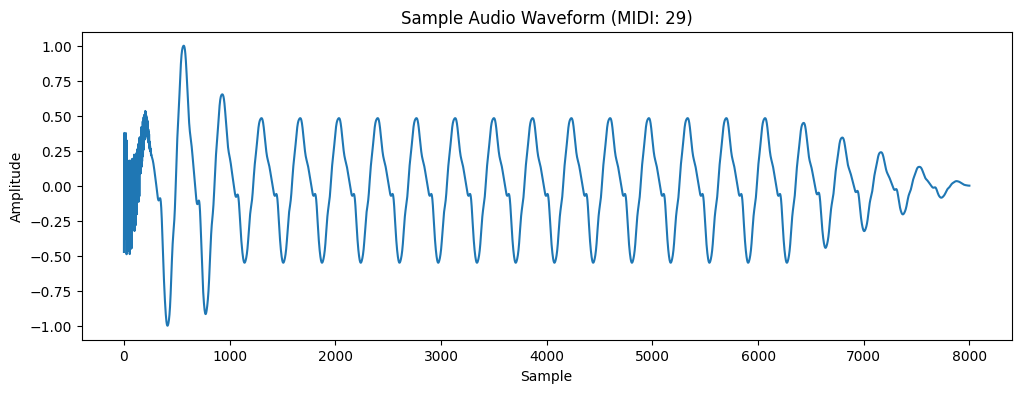

In [2]:
# Create dataset and dataloader
dataset = SyntheticNotesDataset(num_samples=5000, duration=0.5)  # 0.5-second notes
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# Let's listen to a sample
sample_audio, sample_midi = dataset[0]
print(f"Generated note with MIDI pitch: {sample_midi.item() + dataset.min_midi}")
display(Audio(sample_audio.numpy(), rate=16000))

# Plot the sample
plt.figure(figsize=(12, 4))
plt.plot(sample_audio.numpy())
plt.title(f"Sample Audio Waveform (MIDI: {sample_midi.item() + dataset.min_midi})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

In [8]:
# Initialize model
input_length = 8000  # 0.5 seconds at 16kHz
original_model = WaveNetAutoencoder(input_length=input_length, latent_dim=128, num_dilated_layers=5).to(device)
original_model.load_state_dict(torch.load('models/wavenet_autoencoder.pth'))

<All keys matched successfully>

In [4]:
# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(original_model.parameters(), lr=0.001)

# Train the model
train_model(original_model, dataloader, optimizer, criterion, num_epochs=10)

Training Progress:   0%|          | 0/10 [00:03<?, ?it/s, Batch Loss=0.019624]

KeyboardInterrupt: 

In [2]:
# Save
torch.save(original_model.state_dict(), 'models/wavenet_autoencoder.pth')

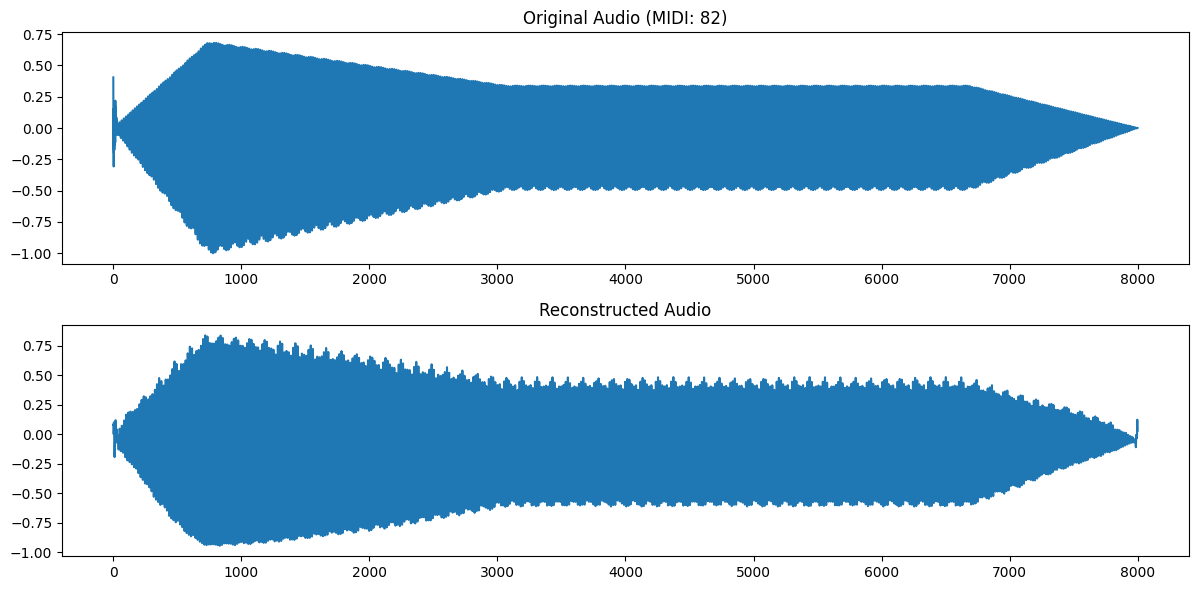

Original:


Reconstructed:


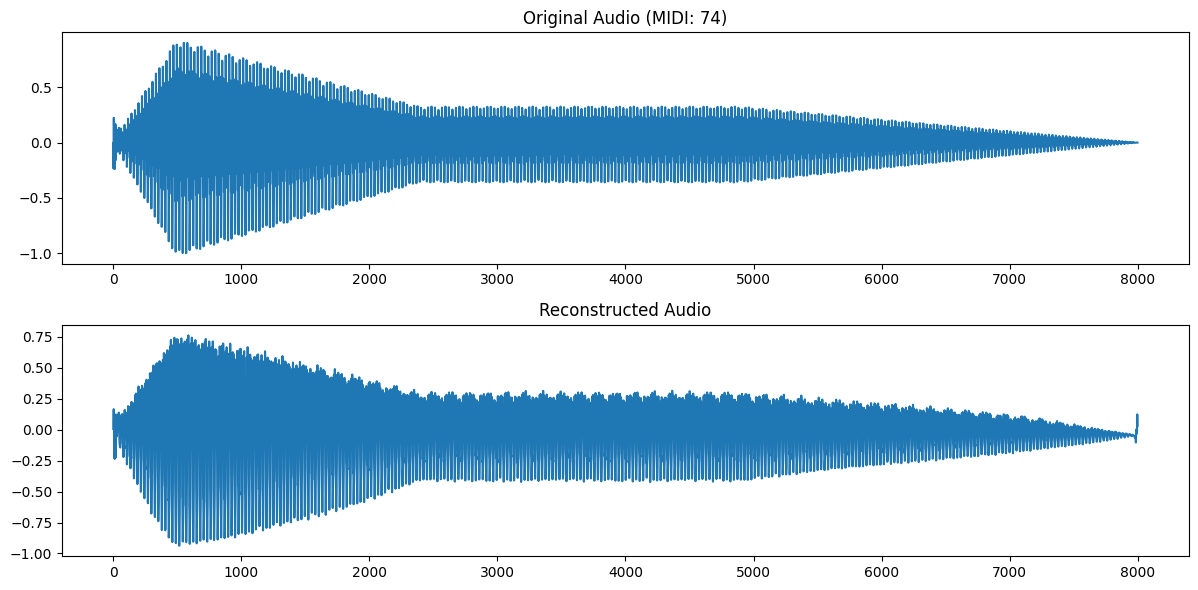

Original:


Reconstructed:


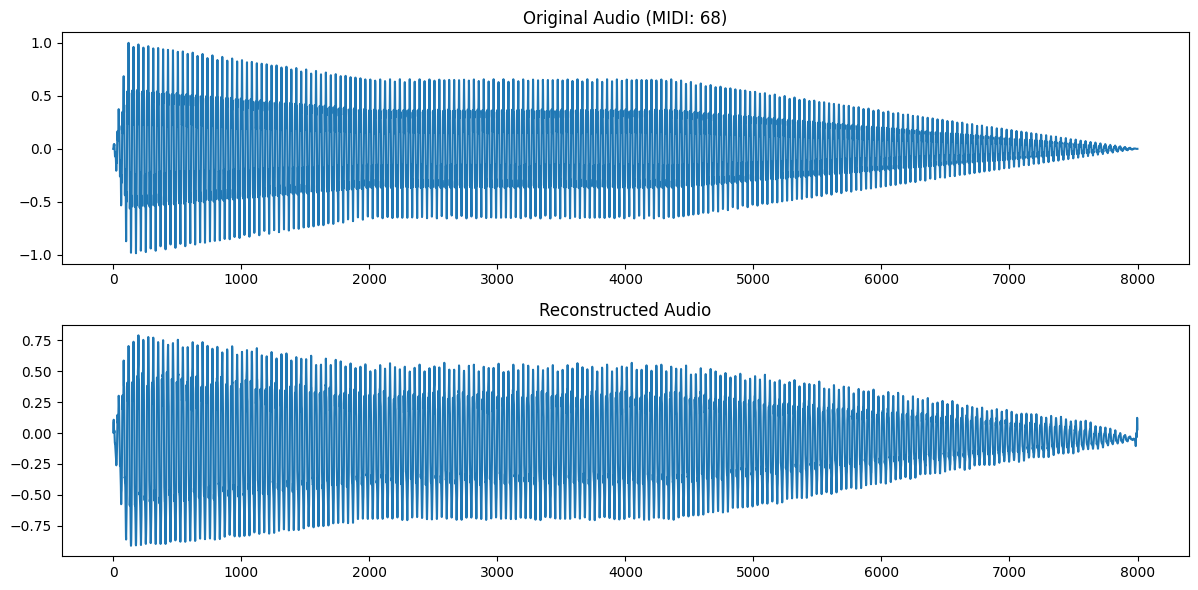

Original:


Reconstructed:


In [5]:
# Evaluate
evaluate_model(original_model, dataset)

In [10]:
# Initialize the enhanced model
disentangled_model = DisentangledWaveNetAE(
    input_length=8000,
    latent_dim=128,
    num_dilated_layers=5,
    bottleneck_dim=32,
    num_pitches=88
).to(device)
disentangled_model.load_state_dict(torch.load('models/disentangled_wavenet_autoencoder.pth'))

<All keys matched successfully>

In [4]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(disentangled_model.parameters(), lr=0.001)

# Train the model
train_disentangled(disentangled_model, dataloader, optimizer, criterion, num_epochs=10, adv_weight=1e-4)

Training Progress:  10%|█         | 1/10 [00:40<06:01, 40.15s/it, Recon Loss=0.0116, Pitch Acc=0.00]


Epoch 1 Summary:
Reconstruction Loss: 0.064289
Pitch Prediction Loss: 4.469958
Discriminator Loss: 4.470197


Training Progress:  20%|██        | 2/10 [01:19<05:18, 39.83s/it, Recon Loss=0.0089, Pitch Acc=0.00]


Epoch 2 Summary:
Reconstruction Loss: 0.024919
Pitch Prediction Loss: 4.455828
Discriminator Loss: 4.455831


Training Progress:  30%|███       | 3/10 [01:58<04:37, 39.64s/it, Recon Loss=0.0032, Pitch Acc=0.00]


Epoch 3 Summary:
Reconstruction Loss: 0.018146
Pitch Prediction Loss: 4.436028
Discriminator Loss: 4.436107


Training Progress:  40%|████      | 4/10 [02:37<03:57, 39.54s/it, Recon Loss=0.0038, Pitch Acc=0.00]


Epoch 4 Summary:
Reconstruction Loss: 0.010610
Pitch Prediction Loss: 4.406883
Discriminator Loss: 4.406937


Training Progress:  50%|█████     | 5/10 [03:17<03:17, 39.51s/it, Recon Loss=0.0034, Pitch Acc=0.00]


Epoch 5 Summary:
Reconstruction Loss: 0.006595
Pitch Prediction Loss: 4.372529
Discriminator Loss: 4.372663


Training Progress:  60%|██████    | 6/10 [03:56<02:37, 39.48s/it, Recon Loss=0.0053, Pitch Acc=0.00]


Epoch 6 Summary:
Reconstruction Loss: 0.005842
Pitch Prediction Loss: 4.336659
Discriminator Loss: 4.337064


Training Progress:  70%|███████   | 7/10 [04:35<01:58, 39.44s/it, Recon Loss=0.0056, Pitch Acc=0.00]


Epoch 7 Summary:
Reconstruction Loss: 0.005431
Pitch Prediction Loss: 4.271110
Discriminator Loss: 4.270964


Training Progress:  80%|████████  | 8/10 [05:15<01:18, 39.42s/it, Recon Loss=0.0038, Pitch Acc=0.12]


Epoch 8 Summary:
Reconstruction Loss: 0.004217
Pitch Prediction Loss: 4.241003
Discriminator Loss: 4.241380


Training Progress:  90%|█████████ | 9/10 [05:54<00:39, 39.35s/it, Recon Loss=0.0010, Pitch Acc=0.00]


Epoch 9 Summary:
Reconstruction Loss: 0.003786
Pitch Prediction Loss: 4.218948
Discriminator Loss: 4.218859


Training Progress: 100%|██████████| 10/10 [06:33<00:00, 39.38s/it, Recon Loss=0.0014, Pitch Acc=0.00]


Epoch 10 Summary:
Reconstruction Loss: 0.003546
Pitch Prediction Loss: 4.181037
Discriminator Loss: 4.181019


In [6]:
torch.save(model.state_dict(), 'models/disentangled_wavenet_autoencoder.pth')

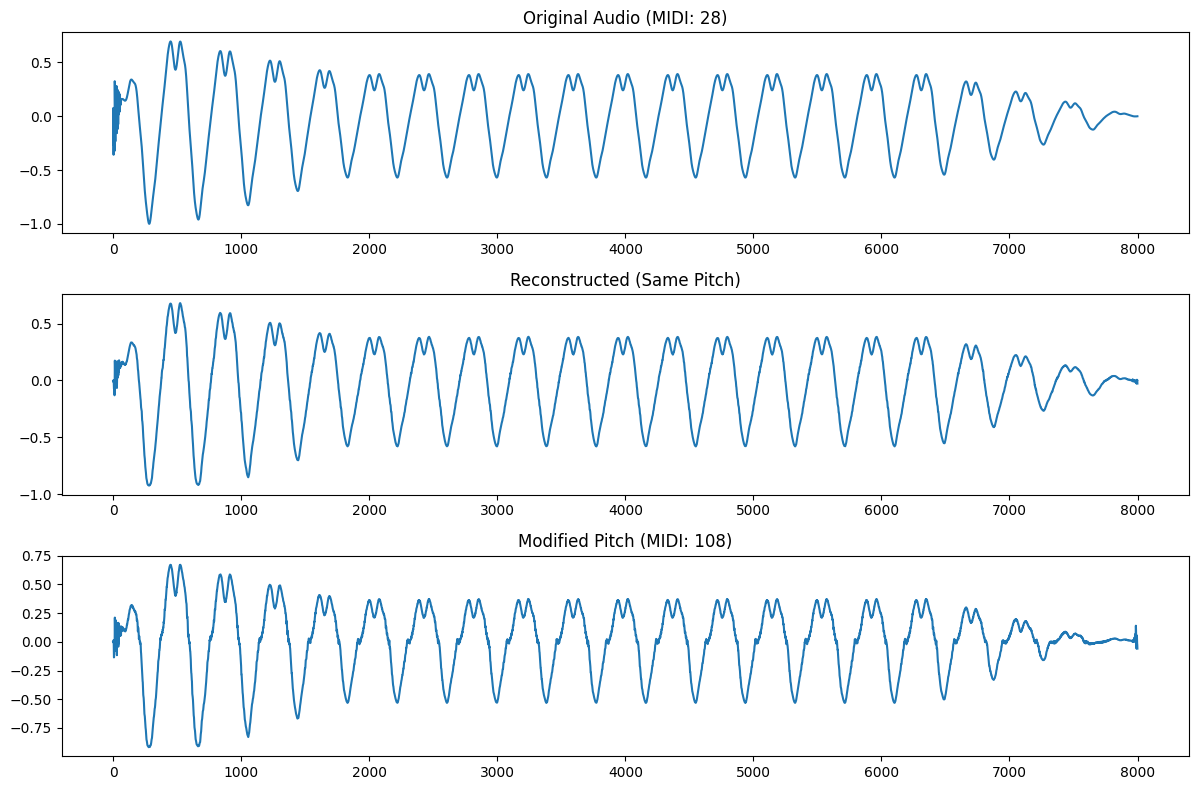

Original:


Reconstructed (same pitch):


Modified (new pitch 108):


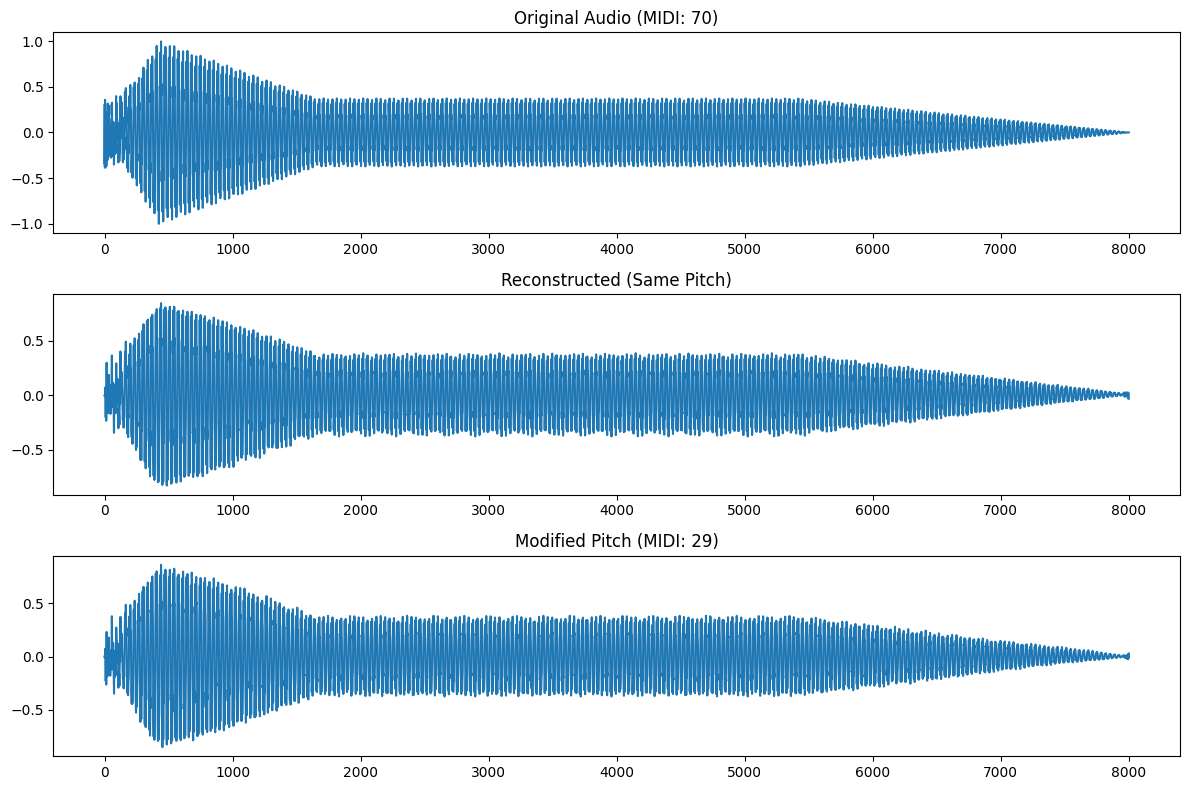

Original:


Reconstructed (same pitch):


Modified (new pitch 29):


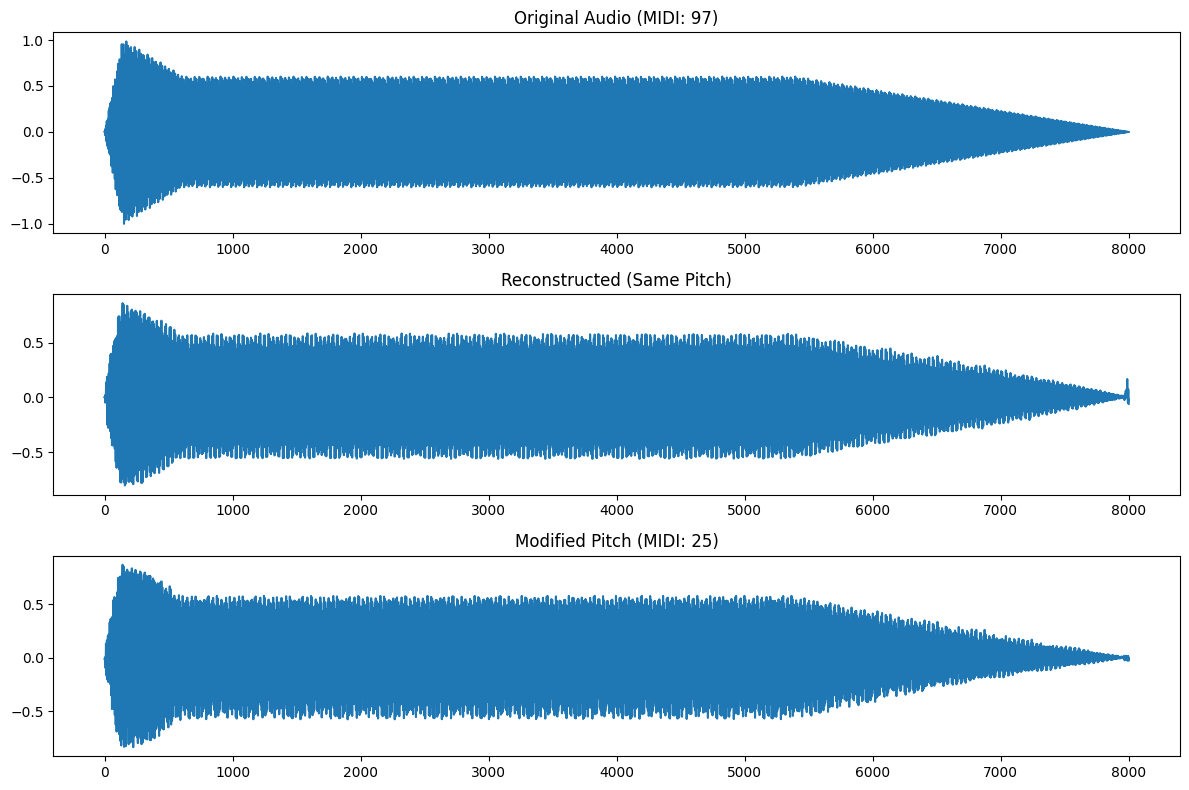

Original:


Reconstructed (same pitch):


Modified (new pitch 25):


In [5]:
# Evaluate with pitch control
evaluate_with_pitch_control(model, dataset)

In [14]:
def compare_models(original_model, disentangled_model, dataset, num_samples=5):
    """
    Compare the original and disentangled models across multiple metrics
    """
    results = {}
    
    # Set models to evaluation mode
    original_model.eval()
    disentangled_model.eval()
    
    # 1. Basic Reconstruction Quality
    print("\n=== Reconstruction Quality ===")
    recon_losses = {'original': [], 'disentangled': []}
    with torch.no_grad():
        for i in tqdm(range(num_samples), desc="Evaluating reconstruction"):
            audio, midi = dataset[i]
            audio = audio.unsqueeze(0).unsqueeze(0).to(device)
            midi = midi.to(device)
            
            # Original model
            orig_recon = original_model(audio)
            orig_loss = F.mse_loss(orig_recon, audio)
            recon_losses['original'].append(orig_loss.item())
            
            # Disentangled model
            dis_recon = disentangled_model.decode(disentangled_model.encode(audio), midi)
            dis_loss = F.mse_loss(dis_recon, audio)
            recon_losses['disentangled'].append(dis_loss.item())
            
            # Plot first sample
            if i == 0:
                plt.figure(figsize=(12, 6))
                plt.plot(audio.squeeze().cpu().numpy(), label='Original', alpha=0.7)
                plt.plot(orig_recon.squeeze().cpu().numpy(), label='Original Model', alpha=0.7)
                plt.plot(dis_recon.squeeze().cpu().numpy(), label='Disentangled Model', alpha=0.7)
                plt.legend()
                plt.title("Reconstruction Comparison")
                plt.show()
                
                print("Original Audio:")
                display(Audio(audio.squeeze().cpu().numpy(), rate=16000))
                print("Original Model Reconstruction:")
                display(Audio(orig_recon.squeeze().cpu().numpy(), rate=16000))
                print("Disentangled Model Reconstruction:")
                display(Audio(dis_recon.squeeze().cpu().numpy(), rate=16000))
    
    results['reconstruction_loss'] = {
        'original': np.mean(recon_losses['original']),
        'disentangled': np.mean(recon_losses['disentangled'])
    }
    print(f"\nAverage Reconstruction Loss:")
    print(f"Original: {results['reconstruction_loss']['original']:.6f}")
    print(f"Disentangled: {results['reconstruction_loss']['disentangled']:.6f}")
    
    # 2. Pitch Control Accuracy
    print("\n=== Pitch Control Accuracy ===")
    pitch_accuracies = {'original': [], 'disentangled': []}
    with torch.no_grad():
        for i in tqdm(range(num_samples), desc="Evaluating pitch control"):
            audio, original_midi = dataset[i]
            audio = audio.unsqueeze(0).unsqueeze(0).to(device)
            original_midi = original_midi.to(device)
            
            # Get latent codes
            orig_z = original_model.encode(audio)
            dis_z = disentangled_model.encode(audio)
            
            # Test pitch change (shift by +12 semitones)
            new_pitch = (original_midi + 12) % 88  # Wrap around if needed
            
            # Original model reconstruction with new pitch
            # (Note: original model doesn't have proper pitch conditioning)
            orig_recon_new = original_model.decode(orig_z)
            
            # Disentangled model with new pitch
            dis_recon_new = disentangled_model.decode(dis_z, new_pitch)
            
            # Calculate pitch accuracy (crude F0 estimation)
            def estimate_pitch(audio):
                audio_np = audio.squeeze().cpu().numpy()
                fft = np.fft.rfft(audio_np)
                frequencies = np.fft.rfftfreq(len(audio_np), 1/16000)
                magnitude = np.abs(fft)
                peak_freq = frequencies[np.argmax(magnitude[1:]) + 1]  # Skip DC
                return peak_freq
            
            # Calculate expected frequency for original and new pitch
            expected_orig_freq = 440 * (2 ** ((original_midi.item() + 21 - 69) / 12))
            expected_new_freq = 440 * (2 ** ((new_pitch.item() + 21 - 69) / 12))
            
            # Estimate actual frequencies
            orig_freq = estimate_pitch(orig_recon_new)
            dis_freq = estimate_pitch(dis_recon_new)
            
            # Calculate accuracy (within ±5% of expected frequency)
            orig_acc = 1 if abs(orig_freq - expected_orig_freq)/expected_orig_freq < 0.05 else 0
            dis_acc = 1 if abs(dis_freq - expected_new_freq)/expected_new_freq < 0.05 else 0
            
            pitch_accuracies['original'].append(orig_acc)
            pitch_accuracies['disentangled'].append(dis_acc)
            
            # Plot first sample
            if i == 0:
                plt.figure(figsize=(12, 8))
                
                plt.subplot(2, 1, 1)
                plt.plot(orig_recon_new.squeeze().cpu().numpy())
                plt.title(f"Original Model - Expected: {expected_orig_freq:.1f}Hz, Actual: {orig_freq:.1f}Hz")
                
                plt.subplot(2, 1, 2)
                plt.plot(dis_recon_new.squeeze().cpu().numpy())
                plt.title(f"Disentangled Model - Expected: {expected_new_freq:.1f}Hz, Actual: {dis_freq:.1f}Hz")
                
                plt.tight_layout()
                plt.show()
                
                print("Original Model (no pitch control):")
                display(Audio(orig_recon_new.squeeze().cpu().numpy(), rate=16000))
                print("Disentangled Model (with pitch control):")
                display(Audio(dis_recon_new.squeeze().cpu().numpy(), rate=16000))
    
    results['pitch_accuracy'] = {
        'original': np.mean(pitch_accuracies['original']),
        'disentangled': np.mean(pitch_accuracies['disentangled'])
    }
    print(f"\nPitch Control Accuracy:")
    print(f"Original: {results['pitch_accuracy']['original']*100:.1f}%")
    print(f"Disentangled: {results['pitch_accuracy']['disentangled']*100:.1f}%")
    
    # 3. Timbre Preservation Across Pitches
    print("\n=== Timbre Preservation ===")
    timbre_scores = []
    with torch.no_grad():
        for i in tqdm(range(min(num_samples, 3)), desc="Evaluating timbre preservation"):
            audio, original_midi = dataset[i]
            audio = audio.unsqueeze(0).unsqueeze(0).to(device)
            original_midi = original_midi.to(device)
            
            # Get latent code from disentangled model
            z = disentangled_model.encode(audio)
            
            # Generate at original pitch and +12 semitones
            recon_orig = disentangled_model.decode(z, original_midi)
            recon_high = disentangled_model.decode(z, (original_midi + 12) % 88)
            
            # Calculate spectral similarity (crude measure)
            def spectral_features(audio):
                audio_np = audio.squeeze().cpu().numpy()
                fft = np.fft.rfft(audio_np)
                magnitude = np.abs(fft)[1:50]  # First 50 bins (skip DC)
                return magnitude / np.sum(magnitude)
            
            feat_orig = spectral_features(recon_orig)
            feat_high = spectral_features(recon_high)
            
            # Cosine similarity
            similarity = np.dot(feat_orig, feat_high) / (np.linalg.norm(feat_orig) * np.linalg.norm(feat_high))
            timbre_scores.append(similarity)
            
            # Plot first sample
            if i == 0:
                plt.figure(figsize=(12, 6))
                
                plt.subplot(1, 2, 1)
                plt.bar(range(len(feat_orig)), feat_orig)
                plt.title(f"Original Pitch {original_midi.item() + 21}")
                
                plt.subplot(1, 2, 2)
                plt.bar(range(len(feat_high)), feat_high)
                plt.title(f"Higher Pitch {(original_midi.item() + 12) % 88 + 21}")
                
                plt.suptitle(f"Spectral Similarity: {similarity:.3f}")
                plt.tight_layout()
                plt.show()
                
                print("Original Pitch:")
                display(Audio(recon_orig.squeeze().cpu().numpy(), rate=16000))
                print("Higher Pitch:")
                display(Audio(recon_high.squeeze().cpu().numpy(), rate=16000))
    
    results['timbre_similarity'] = np.mean(timbre_scores)
    print(f"\nAverage Timbre Similarity Across Pitches: {results['timbre_similarity']:.3f}")
    
    # 4. Latent Space Analysis (Fixed version)
    print("\n=== Latent Space Analysis ===")
    with torch.no_grad():
        # Collect embeddings for different pitches
        all_embeddings = {'original': [], 'disentangled': []}
        all_pitches = []
        
        # Get multiple samples with different pitches
        for i in range(10):
            audio, midi = dataset[np.random.randint(len(dataset))]
            audio = audio.unsqueeze(0).unsqueeze(0).to(device)
            midi = midi.to(device)
            
            # Get embeddings
            orig_emb = original_model.encode(audio)
            dis_emb = disentangled_model.encode(audio)
            
            # Average over time dimension
            all_embeddings['original'].append(orig_emb.mean(-1).squeeze().cpu().numpy())
            all_embeddings['disentangled'].append(dis_emb.mean(-1).squeeze().cpu().numpy())
            all_pitches.append(midi.item())
        
        # Convert to numpy arrays
        orig_embeddings = np.array(all_embeddings['original'])
        dis_embeddings = np.array(all_embeddings['disentangled'])
        pitches = np.array(all_pitches)
        
        # Calculate pitch correlation for each dimension
        def calculate_correlations(embeddings, pitches):
            correlations = []
            for dim in range(embeddings.shape[1]):
                corr = np.corrcoef(embeddings[:, dim], pitches)[0, 1]
                correlations.append(abs(corr))
            return np.mean(correlations)
        
        orig_corr = calculate_correlations(orig_embeddings, pitches)
        dis_corr = calculate_correlations(dis_embeddings, pitches)
        
        results['pitch_correlation'] = {
            'original': orig_corr,
            'disentangled': dis_corr
        }
        
        print(f"\nPitch Information in Latent Space:")
        print(f"Original Model: {orig_corr:.3f}")
        print(f"Disentangled Model: {dis_corr:.3f}")
        
        # Plot first 2 dimensions
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(orig_embeddings[:, 0], orig_embeddings[:, 1], c=pitches)
        plt.colorbar(label='MIDI Pitch')
        plt.title("Original Model Latent Space")
        
        plt.subplot(1, 2, 2)
        plt.scatter(dis_embeddings[:, 0], dis_embeddings[:, 1], c=pitches)
        plt.colorbar(label='MIDI Pitch')
        plt.title("Disentangled Model Latent Space")
        
        plt.tight_layout()
        plt.show()
    
    return results

# Load models (assuming they've been trained and saved)
original_model = WaveNetAutoencoder(input_length=8000).to(device)
original_model.load_state_dict(torch.load('models/wavenet_autoencoder.pth'))

disentangled_model = DisentangledWaveNetAE(input_length=8000).to(device)
disentangled_model.load_state_dict(torch.load('models/disentangled_wavenet_autoencoder.pth'))

# Run comparison
comparison_results = compare_models(original_model, disentangled_model, dataset)

# Print final summary
print("\n=== Final Comparison Summary ===")
print("1. Reconstruction Quality:")
print(f"   Original: {comparison_results['reconstruction_loss']['original']:.6f}")
print(f"   Disentangled: {comparison_results['reconstruction_loss']['disentangled']:.6f}")

print("\n2. Pitch Control Accuracy:")
print(f"   Original: {comparison_results['pitch_accuracy']['original']*100:.1f}%")
print(f"   Disentangled: {comparison_results['pitch_accuracy']['disentangled']*100:.1f}%")

print("\n3. Timbre Preservation:")
print(f"   Spectral Similarity: {comparison_results['timbre_similarity']:.3f}")

print("\n4. Latent Space Analysis:")
print(f"   Pitch Correlation in Latent Space:")
print(f"   Original: {comparison_results['pitch_correlation']['original']:.3f}")
print(f"   Disentangled: {comparison_results['pitch_correlation']['disentangled']:.3f}")

FileNotFoundError: [Errno 2] No such file or directory: 'wavenet_autoencoder.pth'